In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ensemble Learning and Random Forests

The idea is to leverage the *wisdom of the crowd*.

Ensemble Learning = Group of predictors

Ensemble method wors best when the predictors are as independent from one another as possible. This is done by training data using very different algorithms, which increases the chance that the algorithms will make very different types of errors, improving the ensemble's accuracy.

Random forest = training a group of decision tree classifiers, each on a different random subset of the training set. Obtain the predictions of all individual trees and the ensemble's prediction is the class that gets the most votes.

## Voting Classifiers

In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples = 500, noise = 0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [5]:
voting_clf.predict(X_test[:1])

array([1])

In [6]:
# the fitted clones are under estimators_attribute
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [7]:
# THE RESULTS ARE BETTER THAN THE INDIVIDUAL MODELS!
voting_clf.score(X_test, y_test)

0.912

We can also use the class probability to do a *soft voting* method where a class is predicted based on the highest class probability (averaged over all the individual classifiers).

Note that SVC does not have the class probability method by default so we need to modify that specific estimator

In [8]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting

An approach to get a diverse set of classifiers is to use the same training algorithm for every predictor, but trained on different random subsets of the training set.

When sampling is done **WITH** replacement, then it is called *bagging*. <br>
When sampling is performed **WITHOUT** replacement, it is called *pasting*.

Generally, the net result is that the ensemble has a similar bias, but a lower variance than a single predictor trained on the original training set.

In [9]:
# use BaggingRegressor for regression
# to use pasting, set bootstrap = False
# n_jobs is used to tell the # of CPU cores to use
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100,
                            n_jobs=1, 
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=1, random_state=42)

BaggingClassifier automatically performs soft voting instaed of hard voting if the base classifier can estimate class probabilities (which is the case for decision tree classifier)

Compared to pasting, bagging will end up with a slightly higher bias than pasting, as the subsets will have more diversity. This extra diversity means that predictors end up being less correlated, resulting in reduced variance.

Overall, bagging often results in better models!

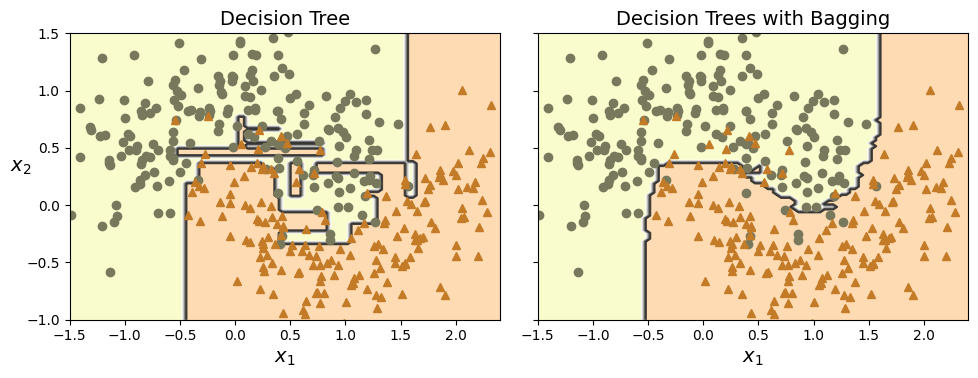

In [10]:
# extra code – this cell generates and saves Figure 7–5
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

The graph above shows that while both DT and DT with bagging have overall the same bias, DT with Bagging has smaller variance (as the decision boundary is less irregular).

## Out-of-Bag Evaluation

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

In [12]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=42)

In [13]:
bag_clf.oob_score_

0.896

In [14]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [15]:
# the OOB decision function for each training instance
# is available through the oob_decision_function_ attribute
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

### Random Patches and Random Subspaces

BaggingClassifier supports sampling features and controlled by 2 hyperparameters
1. max_features
2. bootstrap_features

This technique is particularly useful when dealing with high-dimensional inputs (images), as it can considerably speed up training.

Sampling both training instances and features is called *random patches* method. <br>

Keeping all training instances, but sampling features is called *random subspaces* method.

# Random Forests

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42
)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [17]:
# note that the following BagginClassifier is equivalent to RFC
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(
        max_features="sqrt",
        max_leaf_nodes=16),
    n_estimators=500,
    n_jobs=-1,
    random_state=42
    )

We can also set the splitter="random" to allow for trees to become even more random by having random thresholds for each feature during splitting. This will result in a *extremely randomized trees* (or *extra-trees* for short) ensemble.

Note that this will increase bias but decrease variance.

Extra-tree classifiers can be created using sklearn's ExtraTreesClassifier class (parameters are the same as RandomForestClassifier, except the bootstrap defaults to False).

### Feature Importance

Sklearn measure importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. Specifically it is a weighted average (each node's weight = umber of trianing samples associated with it).

In [18]:
# done un the iris dataset
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score,2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


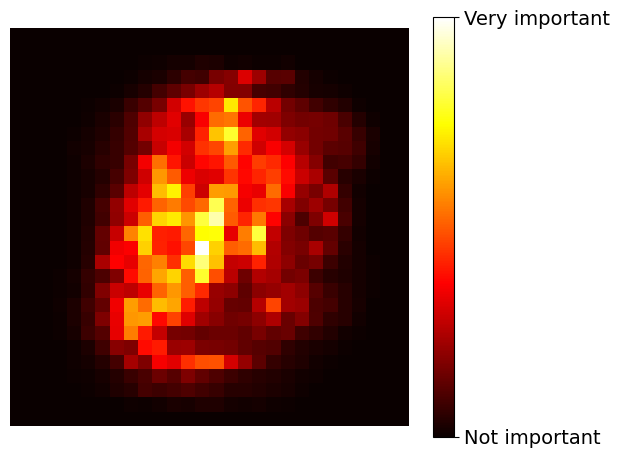

In [19]:
# extra code – this cell generates and saves Figure 7–6
# MNIST pixel importance (according to a random forest classifier)
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting

Any ensemble method that can combine several weak learners into a strong learner. The general idea is to train predictors sequentially, each trying to correct ts predecessor.

## Adaboost (Adaptive Boosting)

Paying more attention to the training instance that the predecessor underfit.

It first trains a base classifier, then uses it to make predictions on the training set. Then the algorihtm increases the relative weight of misclassified training instances and trains a second classifier using the updated weights. And so on and so forth.

The drawback in this technique is that training cannot be prallelized since each predictor can only be trained after the previous predictor has been trained and evaluated. Hence it does not scale as well as bagging or pasting.

In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

## Gradient Boosting

Works like AdaBoost, but instead of tweaking the instance weights at every iteration, this method tries to fit the new predictor to the *residual errrors* made by the previous predictor.

In [21]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [22]:
# now train a second DTRegressor on the residual errors
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [23]:
# train a thirs regressor on the residual errors made by the second predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [24]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In [25]:
# Use GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1,
    random_state=42
)

gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

To find the optimal number of trees, peform cross-validation using GridSearchCV or RandomizedSearchCV, but we can also set the n_iter_no_change hyperparameter to an integer $n$ value, then the GradientBoostingRegressor will automatically stop adding more trees during trianing if it sees that the last $n$ trees didn't help.

In [26]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=42
)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [27]:
gbrt_best.n_estimators_

92

When the n_iter_no_change is set, the fit() method will automatically split the training set to smaller trainning set and validation set to allow the model to evaluate the model's performance each time it adds a new tree. The size of the validation set is controlled by the validation_fraction hyperparameter (default is 10%). The tol hyperparameter determines the maximum performance improvement that still counts as negligible (defaults to 0.0001).


Can also use the subsample hyperparameter, which specifies the fraction of training instances to be used for taining each tree. This trades in higher bias for lower variance and also speeds up training. This isc alled *stochastic gradient boosting*.

## Histogram-Based Gradient Boosting (HGB)

This technique is optimized for large datasets and works by binning input features, replacing the with integers to greatly redcuce the number of possible thresholds that the training algorithm needs to evaluate. WOrking with integers also eanbles it to use faster and more memory efficient data structures (removes the need for sorting the features when training each tree).

As a result, it has a computational complexity of O(b x m) instead of O (n x m x log(m)), where b is the number of bins, m is the number of training instances and n i sthe number of features.

However, binning causes precision loss, which acts as a regularizer, depending on the dataset, it may helpreduce overfitting, or may cause underfitting.

It is similiar to GradientBoosting, with the following differences.
1. Early stopping is automatically activated if the number of instances is greater than 10,000. This can be set under the early_stopping hyperparameter;
2. Subsampling is not supported;
3. n_estimators is renamed to max_iter;
4. The only decision tree hyperparameters that can be tweaked are max_leaf_nodes, min_samples, and max_depth;

Finally, HGB support both categorical features and missing values (simplifies preprocessing). For the cateogircal features it must be represented as integers ranging from 0 to a number lower than max_bins. Use the OrdinalEncoder for this.

In [28]:
# from sklearn.pipeline import make_pipeline
# from sklearn.compose import make_column_transformer
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.preprocessing import OrdinalEncoder

# hgb_reg = make_pipeline(
#     make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
#                              remainder="passthrough"),
#     HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
# )

# hgb_reg.fit(housing, housing_labels)

Other gradient boosting are
- XGBoost,
- CatBoost
- LightGBM

# Stacking (Stacked Generalization)

Instead of using trivial function to aggregate predictions of all predictors in an ensemble, we can train a model to perform this aggregation (called *blender* or *meta learner*).

To do this, we need to train the blender by building the blending training set using the corss_val_predict() method on every predictor in the ensemble to get out-of-sample predictions for each instance in the original training set.

In [29]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(probability=True, random_state=42))
    ],
    final_estimator= RandomForestClassifier(random_state=43),
    cv=5
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

If no final estimator is provided, it will use the LogisticRegression (for StackingRegressor it will use RidgeCV)

# Exercises

## 1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why? 

Yes, there is a chance that the models can perform even better than 95%, provided that all the models are very different (SVM, decision tree, logistics regression, etc), and will be even better if it was trained under different training instances (bootstrap).

## 2. What is the difference between hard and soft voting classifiers?

hard voting -> purely based on the majority vote from the estimators <br>
soft voting -> computes the average estimated class probability for each class and picks the class with the highest probability.

## 3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, random forests, or stacking ensembles?

Yes for bagging, pasting and random forest.
For boosting, it cannot be done under multiple servers as subsequent trees depend on the results of the previous tree.

Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.

## 4. What is the benefit of out-of-bag evaluation?

Essentially having a validation set without needing a separate validation set.

Having an accurate enough test set that can be tested under each bootstraped trees, which can proxy for the evaluation test to test the accuracy / error rate of the algorithm.

## 5. What makes extra-trees ensembles more random than regular random forests? How can this extra randomness help? Are extra-trees classifiers slower or faster than regular random forests?

extra-tree ensemble further decolerate trees between bootstrapped samples by randomizing the available features that is considered during splitting (rather than the best). This method trades more bias for lower variance and is much faster to train than regular random forest (algorithm is not considering the best splitting feature during in split nodes).

Note that this speed increase is only for training and not for predicting!

## 6. If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak, and how?

Increase the number of estimators (trees) and decrease the regularization hyperparameter, and mayben slightly increase the learning rate.

## 7. If your gradient boosting ensemble overfits the training set, should you increase or decrease the learning rate?

We should decrease the learning rate or use early stopping to find the right number of predictors.

## 8. Load the MNIST dataset (introduced in Chapter 3).
Split it into a trainingset, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). <br>
Then train various classifiers, such as a random forest classifier, an extra-trees classifier, and an SVM classifier.<br>
Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. <br>
Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

## 9. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions:
Each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. Train a classifier on this new training set.<br>
Now evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s pre‐
dictions. How does it compare to the voting classifier you trained earlier? Now try again using a StackingClassifier instead. Do you get better performance? If so, why?